# $\color{purple}{\text{Spam Detection by the Voting Classifier}}$

*By Alexander Ng & Philip Tanofsky*

*CUNY School of Professional Studies, DATA 620*

*Due April 17, 2022*


# $\color{blue}{\text{Summary}}$

This analysis conducts document classification of the classic `Spambase` dataset into `spam` or `ham` using characteristics of 4601 emails.  We compare the prediction accuracy and merits of multiple machine learning algorithms (KNN,  Adaboost, Stochastic Gradient Descent,  Random Forest, Support Vector Machine, Voting Classifier).   Based on an 80-20 train-test split, we find that:

   *  $\color{blue}{\text{Voting Classifier}}$ has the best accuracy among the tested algorithms at 95.8% accuracy based on a combination of 3 constituent voting models.
   *  Random Forest, Adaboost are the next best models in descending order of accuracy.   Depending on the random seed, their performance ranks can flip.
   *  Support Vector Machine, Stochastic Gradient Descent and KNN are the third tier of models by accuracy.
   *  The most useful text features in detecting spam are the length and frequency of all capital strings in the text.
   
We begin with an overview and exploration of `Spambase` and then apply `scikit-learn` for the machine-learning analysis.   


# $\color{blue}{\text{Exploration of Data}}$

This section focuses on data wrangling and exploratory data analysis of the spam dataset.


In [61]:
# Define the imports
import warnings
warnings.filterwarnings('ignore')
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from matplotlib import cm
import seaborn as sns

`Spambase`contains 4601 observations of email messages.  Of these, 1813 (39.4%) are spam. 
Spambase datafiles are unconventional.  They consist of 3 text files.

*  `spambase.DOCUMENTATION` describes the authors, data sources and unusually detailed metadata and statistical summaries.
*  `spambase.names` contains a commented line of column names for the predictors only.  The useful names begin at row 34.
*  `spambase.data` contains a comma separated data matrix of the attributes of each document (per row) with 57 columns of predictors and 1 column of the label.

The code below first parses `spambase.names` to extract the 57 predictors names and assigns to the rightmost column, the name column `is_spam`.

In [62]:
data_dir = "spambase/"
spam_data_file = os.path.join( data_dir, "spambase.data")
spam_names_file = os.path.join(data_dir, "spambase.names")


In [63]:
df_names = pd.read_csv(spam_names_file, sep=":", skiprows = 32, header =None)

spam_columns = df_names[0].tolist()
spam_columns.append('is_spam')

In [64]:
df_data = pd.read_csv(spam_data_file, header=None)
df_spam = pd.DataFrame( data=df_data.values , columns = spam_columns )

df_spam['is_spam'] = df_spam['is_spam'].astype('int')

with pd.option_context( 'display.precision', 3 , 
                       'display.colheader_justify', 'center' ):
    display(df_spam.describe().transpose().iloc[:,[ 1,3,5, 7] ] )

,mean,min,50%,max
word_freq_make,0.105,0.0,0.000,4.540
word_freq_address,0.213,0.0,0.000,14.280
word_freq_all,0.281,0.0,0.000,5.100
word_freq_3d,0.065,0.0,0.000,42.810
word_freq_our,0.312,0.0,0.000,10.000
word_freq_over,0.096,0.0,0.000,5.880
word_freq_remove,0.114,0.0,0.000,7.270
word_freq_internet,0.105,0.0,0.000,11.110
word_freq_order,0.090,0.0,0.000,5.260
word_freq_mail,0.239,0.0,0.000,18.180


## Conditional Distributions and Means

Conditional distribution of word frequencies with ham and spam messages can be powerful tools to help build predictive models.
Intuitively, we expect ham and spam to have different conditional distributions because they have different subject matter and writing style.   A graphical and numerical approach can be applied to obtain useful insights.

We will use the graphic approach to build intuition and the numerical approach to suggest variable importance in a sortable fashion.

### Graphical Approach

The following panel of plots shows the conditional distributions of each word within
the population of $\color{red}{\text{ham messages}}$ and $\color{blue}{\text{spam messages}}$.
The distributions exclude messages where the word does not occur.

Where the red and blue histograms overlay closely, the word does not differentiate between spam and ham.
However, there the histograms are different, we can expect models to differentiate between ham and spam based on that key word.

For example, in the bottom 2 rows of this panel, we see that the presence of `$` is associated with spam but the presence of the word
`conference` is associated with ham.

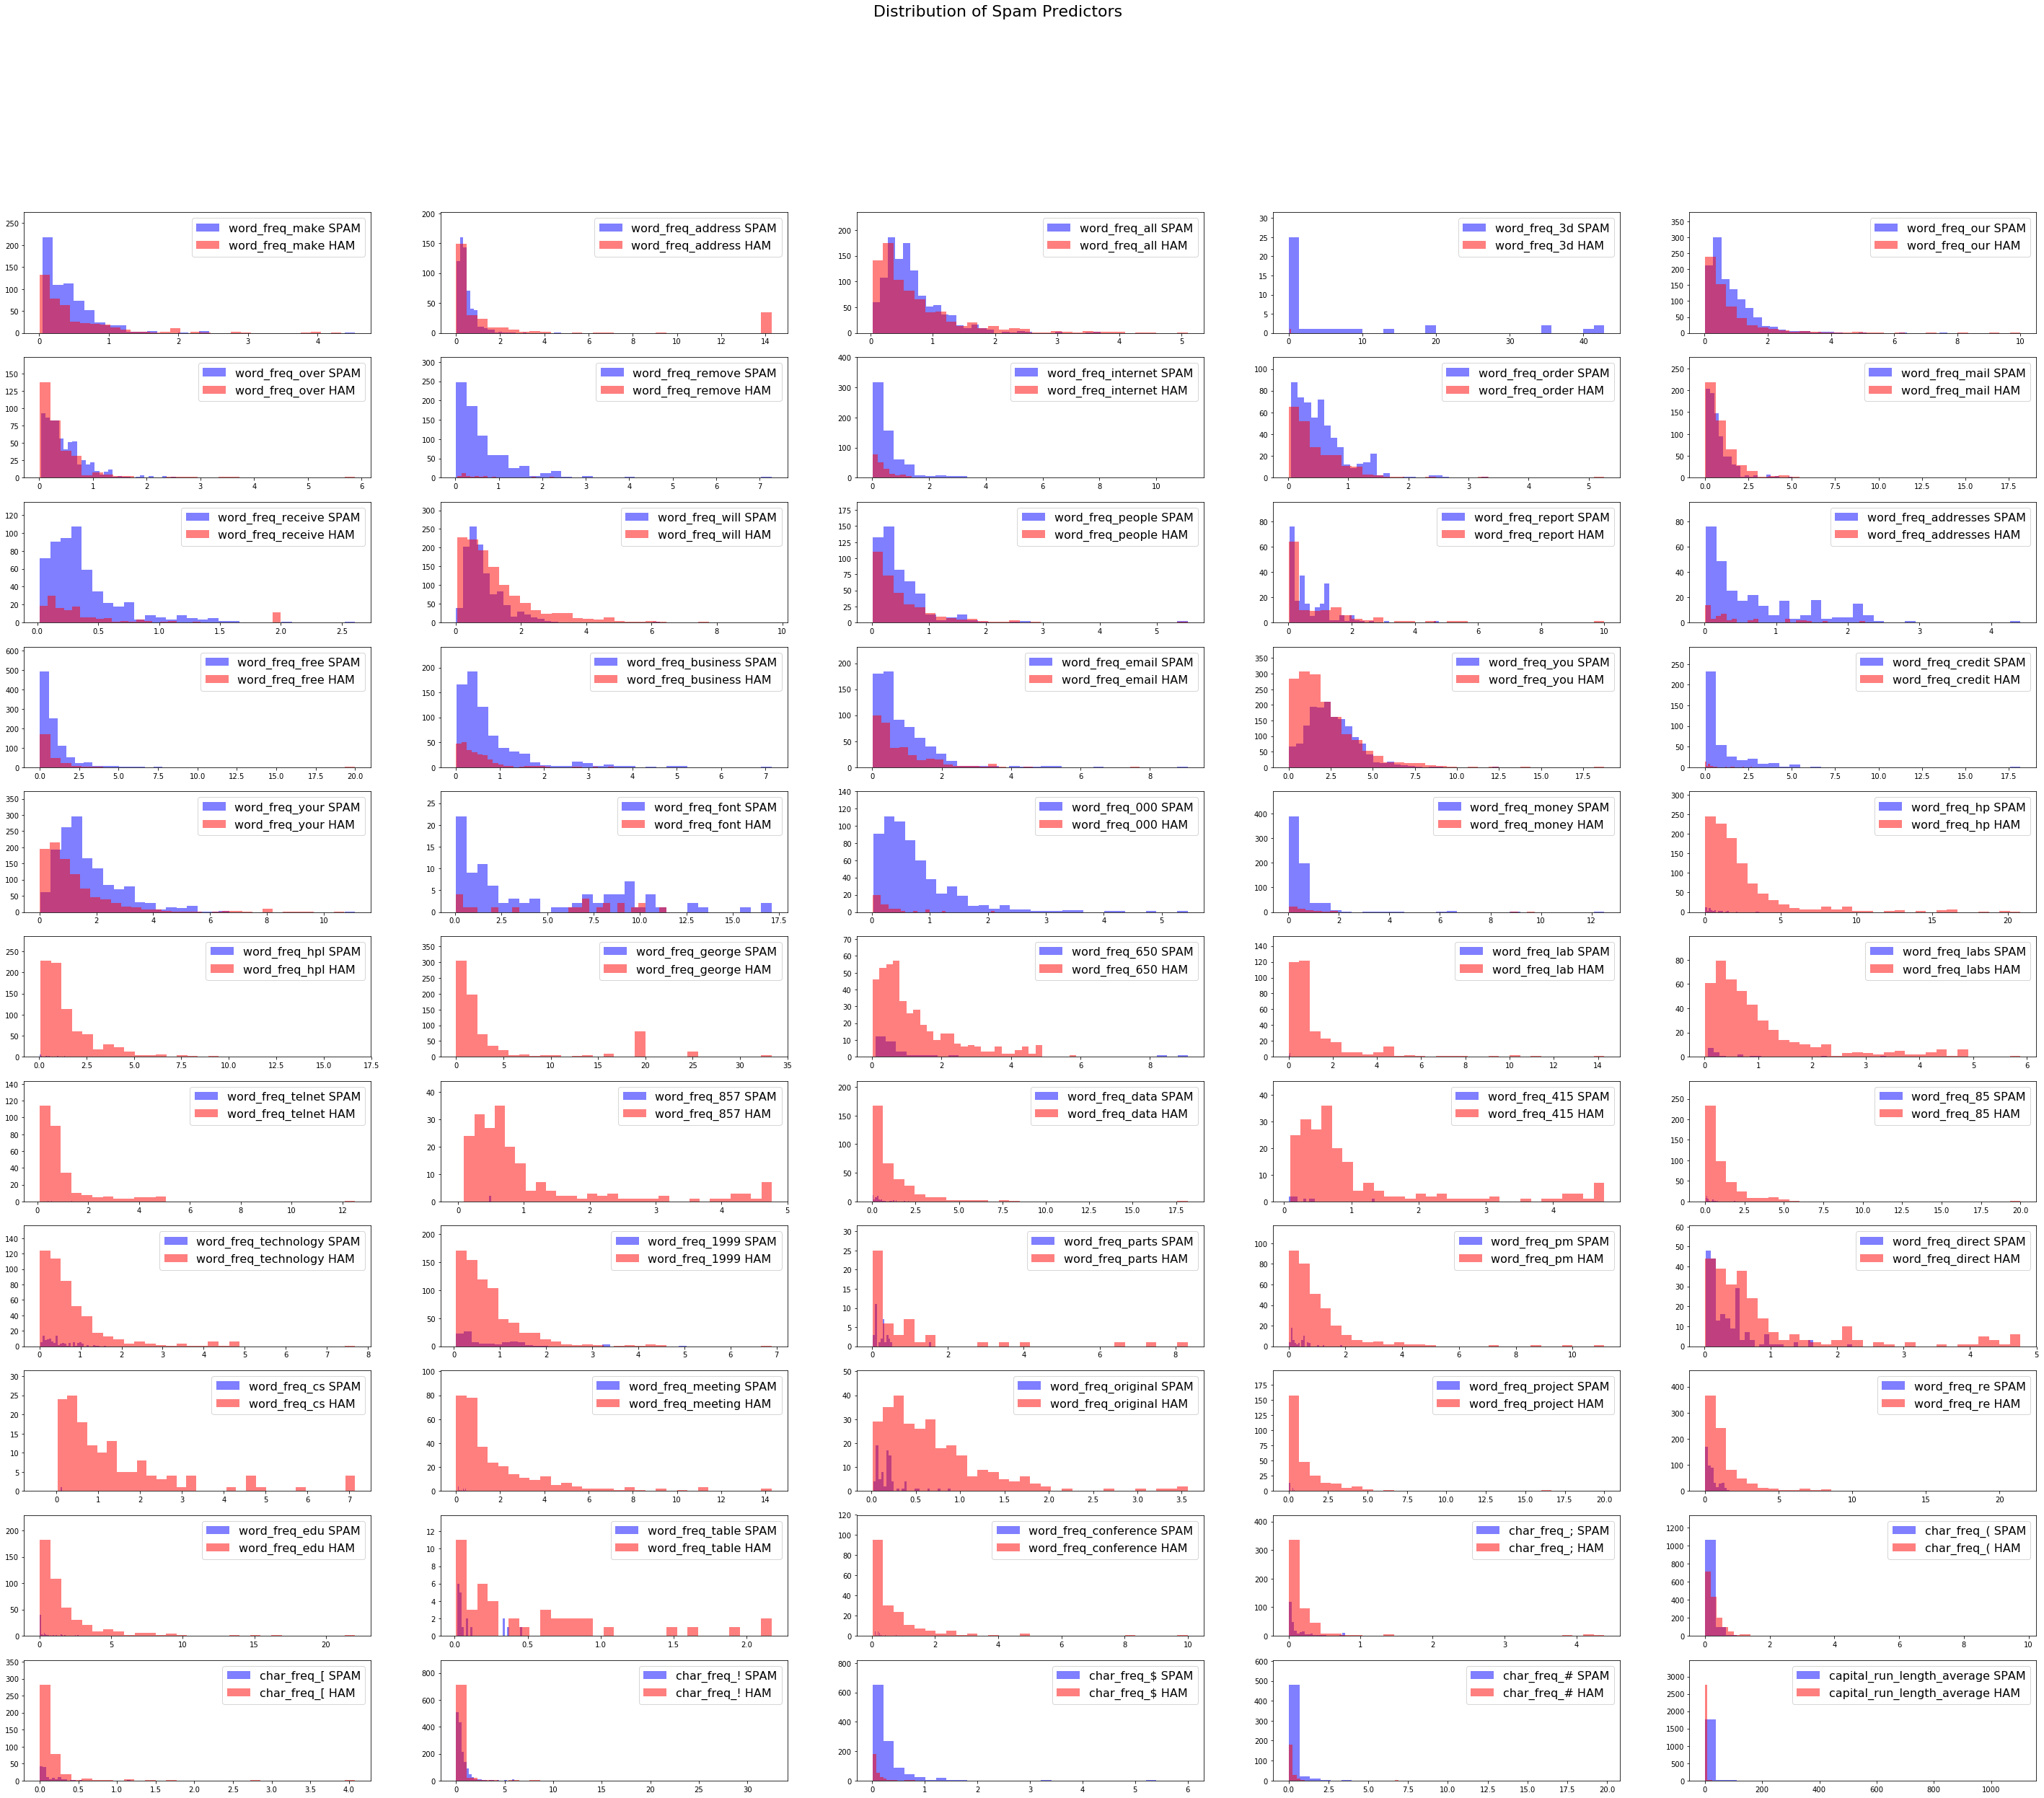

In [65]:

fig, axes = plt.subplots(11,5,figsize=(50,40))

# for index, column in enumerate(strain.iloc[:,0:55].columns):
for index, column in enumerate(df_spam.iloc[:,0:55].columns):
    ax = axes.flatten()[index]
    df_temp_nonzero = df_spam[ df_spam[ column ] > 0 ]
    df_temp_spam = df_temp_nonzero[ df_temp_nonzero[ 'is_spam'] == 1 ]
    df_temp_ham  = df_temp_nonzero[ df_temp_nonzero[ 'is_spam'] == 0 ]
    
    if len(df_temp_spam) > 0:
        ax.hist(df_temp_spam[column],bins=30, label=column + " SPAM", fc="blue", alpha = 0.5)
        
    if len(df_temp_ham) > 0:
        ax.hist(df_temp_ham[column],bins=30, label=column + " HAM", fc="red", alpha = 0.5)
    
    ax.legend(loc='upper right', fontsize=16)
    ax.set_ylim((0,1.2*ax.get_ylim()[1]))

fig.suptitle('Distribution of Spam Predictors', fontsize=22);

### Numerical Approach

Now we ask how strongly each predictor distinguishes `ham` from `spam` by looking at conditional means.   Variables that have good predictors of `ham` vs. `spam` could be expected to show significant differences in conditional expectations.

For each predictor $X$ of an observation email $M$, we compute the 4 summary statistics conditioning on `is_spam`.

*   $\color{green}{\text{ham} = E[ X(M) | M  \text{is not spam}]}$  the conditional mean frequency of a message $M$ containing the given word if $M$ is ham in percentage.

*   $\color{green}{\text{spam} = E[ X(M) | M  \text{ is spam }]}$  the conditional mean frequency of a message $M$ containing the given word if $M$ is spam in percentage.

*   $\color{green}{\text{dhamspam} = E[ X(M) | M \text{ is spam }] - E[ X(M) | M \text{ is not spam }]}$   the difference in conditional frequency between spam and ham in percentage.

*   $\color{green}{\text{rdhamspam} = \frac{\text{dhamspam}}{\text{ham}}}$ - the relative difference in conditional frequency between spam and ham.

The resulting values are displayed sorted by `rdhamspam` below in descending order.

We find that conditional means can be significantly different for ham and spam.

*   The top 21 predictors are over twice as frequent in spam than ham.  For example, `word_freq_3d` is 184 times more frequent in spam than ham.   If we find that the word `3d` in a test email message, the likelihood that the true label is `spam` is much higher than it being ham.
    
*   The bottom predictors are also informative.  They occur almost exclusively in the ham messages.   The word frequencies of `cs`, `george` and `lab` are much higher in ham than spam.


We expect the predictive models to combine the top and bottom predictors in this ranked table to obtain strong predictive performance.

In [66]:
freq_diff = df_spam.groupby('is_spam').mean().transpose().reset_index()
freq_diff2 = pd.DataFrame( data=freq_diff.values , columns = ['freq', 'ham', 'spam'] ).reset_index(drop=True)

freq_diff2["dhamspam"] = freq_diff2["spam"] - freq_diff2["ham"]
freq_diff2["rdhamspam"] = (freq_diff2["spam"]/freq_diff2["ham"]) - 1

with pd.option_context('display.precision', 3 , 
                       'display.colheader_justify', 'center' ):
    display(freq_diff2.sort_values(by = "rdhamspam", ascending=False))

,freq,ham,spam,dhamspam,rdhamspam
3,word_freq_3d,0.001,0.165,0.164,184.872
22,word_freq_000,0.007,0.247,0.24,33.858
6,word_freq_remove,0.009,0.275,0.266,28.351
19,word_freq_credit,0.008,0.206,0.198,26.118
52,char_freq_$,0.012,0.174,0.163,13.979
14,word_freq_addresses,0.008,0.112,0.104,12.475
23,word_freq_money,0.017,0.213,0.196,11.422
15,word_freq_free,0.074,0.518,0.445,6.044
16,word_freq_business,0.048,0.288,0.239,4.947
55,capital_run_length_longest,18.214,104.393,86.179,4.731


# $\color{blue}{\text{Model Preparation}}$

We use the `scikit-learn` framework to run the data workflow and models.
To build our data science workflow, we relied extensively on the excellent tutorial in [**Hands-on Machine Learning with Scikit-Learn, Keras & TensorFlow**](https://www.amazon.com/gp/product/1492032646) , 2nd edition, by Aurielien Geron and associated [github repository](https://github.com/ageron/handson-ml) in addition to the [**scikit-learn**](https://scikit-learn.org/stable/user_guide.html) online documentation.

## Test-Train Split

Next, we produce an 80-20 train-test split for the data using a pre-determined seed for the random shuffling.
Note, that we choose to take a stratified sample.  This means that the training and test sets both have approximately 39.4% spam in their respective data samples.
Furthermore, we alias the training set as `strain` and the test set as `stest`.  Moreover, to discretize the response variable, we replace `is_spam`, an integer variable, by `b_spam`, a Boolean variable. `b_spam` = `True` iff a message is labeled as `is_spam` = `1`.

In [67]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit( n_splits = 1, test_size = 0.2, random_state = 212 )

for train_index, test_index in split.split(df_spam , df_spam["is_spam"] ):
    stratified_training_set  = df_spam.loc[ train_index ]
    stratified_test_set = df_spam.loc[ test_index ]

stratified_training_set["b_spam"] = np.where( stratified_training_set["is_spam"] == 1 , True, False )
stratified_test_set["b_spam"] = np.where( stratified_test_set["is_spam"] == 1 , True, False )


strain = stratified_training_set.drop('is_spam', axis = 1 )
stest  = stratified_test_set.drop('is_spam' , axis = 1)

In [68]:
strainX = strain.drop("b_spam", axis = 1 )
strainY = strain["b_spam"].copy()

stestX  = stest.drop("b_spam", axis = 1 )
stestY  = stest["b_spam"].copy()

In [69]:
strainY.value_counts(), stestY.value_counts()

(False    2230
 True     1450
 Name: b_spam, dtype: int64,
 False    558
 True     363
 Name: b_spam, dtype: int64)

## Transformations

What transformations are necessary?   Since all the predictors are non-null and do not appear to have outliers, we are fortunate to have clean input data.

Thus, our data transformation pipeline will only be to normalize the highly variable data.  The range of possible means and standard deviations is large because
some words occur much more frequently than others.  We apply a Z-score standardized transformation for each predictor.


In [70]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline= Pipeline([ ( 'std_scaler', StandardScaler() ) ] )

We use the `ColumnTransformer` class in `scikit-learn` to gather all pipeline transformers for numerical and categorical data.
Since there are no categorical predictors, `ColumnTransformer` is not fully utilized but still generally applicable.
We keep it as a best practice for future analyses.

In [71]:
from sklearn.compose import ColumnTransformer

num_attribs = list(strainX)

full_pipeline = ColumnTransformer( [ ("num", num_pipeline , num_attribs ) ] )

prepared_strainX = full_pipeline.fit_transform( strainX )

prepared_stestX = full_pipeline.transform( stestX)

We observe that the prepared data is a mean 0, variance 1 variable set now as expected.

In [72]:
prepared_strainX.mean(), prepared_strainX.std()

(4.674623261579606e-18, 1.0)

# Model Results

We run a variety of machine learning algorithms below.  The Python inclusion directives are grouped here for convenience.


In [73]:
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import cross_val_predict, cross_val_score, RepeatedStratifiedKFold

from sklearn.metrics import confusion_matrix , accuracy_score, f1_score, precision_score, recall_score
from sklearn import metrics

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.linear_model import SGDClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

from sklearn.inspection import permutation_importance


We write some helper functions to code up standard binary classification performance measures.
Note that the orientation of the confusion matrix is non-standard and needed to be coded directly.
In addition, we include the **Matthews Correlation Coefficient (MCC)** as an output statistic.

In [74]:
#  Helper function to compute binary classification
#  performance statistics.   Accepts a confusion matrix
#  produced by scikit learn
#
#  Returns a list of number:  accuracy,   precision, recall, f1,  matthews correlation coefficient
#
def performance_statistics(confusionMatrix):
    
    cm = confusionMatrix
    TP, FP , FN , TN = cm[1,1], cm[0,1], cm[1,0], cm[0,0]
    
    accuracy   =  (TP + TN)/(TP + TN + FP + FN)
    precision  =  TP / ( TP + FP )
    recall     =  TP / ( TP + FN )
    F1         =  (2 * TP) / ( 2 * TP + FP + FN )
    MCC        =  ( TP * TN - FP * FN ) / math.sqrt( (TP + FP ) *( TP + FN ) *( TN + FP)*(TN + FN ) )
    
    results = [ accuracy, precision, recall, F1, MCC, TP, FP, FN, TN ]
    return results

def report_confusion_matrix( actual_Y, pred_Y, label):
    
    cm = confusion_matrix( actual_Y, pred_Y )
    
    xout = performance_statistics( cm )
    
    acc = xout[0]
    f1 =  xout[3]
    precision = xout[1]
    recall = xout[2]
    mcc    = xout[4]
    TP =  xout[5]
    FP =  xout[6]
    FN =  xout[7]
    TN =  xout[8]
    
    print("Data set: ", label )

    print( "Accuracy (%) : {:.2f}".format( acc * 100 ) )
    print( "F1 Score (%) : {:.2f}".format( f1 * 100 ) )
    print( "Precision (%): {:.2f}".format( precision * 100) )
    print( "Recall   (%) : {:.2f}".format( recall * 100 ) )
    print( "MCC (%)      : {:.2f}".format( mcc * 100 ) )
    print( "\n Confusion Matrix: \n" )
    print( "  {:4d}  {:4d}\n  {:4d}  {:4d}\n".format( TP, FN,  FP,  TN ) )
    
    
    return cm


## KNN Analysis

We run a K-nearest neighbor algorithm which shows that the optimal accuracy arises from $k = 13$ neighbors. 

The plot shows the value of $k$ on the x-axis from $1 \ldots 25$ and makes clear that $k = 13$ is optimal.
This is confirmed by the table below where we display the first 15 values.

In [75]:

k_range = range(1, 25)

knn_scores = {}
knn_scores_list = []

for k in k_range:
    knn_mod = KNeighborsClassifier(n_neighbors = k )
    knn_mod.fit( prepared_strainX, strainY)
    y_pred_knn = knn_mod.predict(prepared_stestX)
    knn_scores[ k ] = metrics.accuracy_score( stestY, y_pred_knn )
    knn_scores_list.append( knn_scores[k] )

Text(0,0.5,'Test Accuracy')

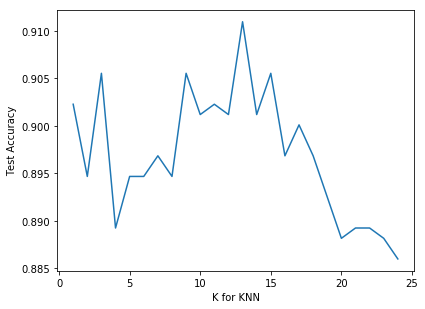

In [76]:
# Now plot the accuracy as a function of the number of nearest neighbors to average
plt.plot(k_range, knn_scores_list )
plt.xlabel( 'K for KNN')
plt.ylabel('Test Accuracy')

In [77]:
df_results_knn = pd.DataFrame( list( zip( k_range ,knn_scores_list ) ), columns = ['k', 'accuracy'] )

df_results_knn[:15]

,k,accuracy
0,1,0.902280
1,2,0.894680
2,3,0.905537
3,4,0.889251
4,5,0.894680
5,6,0.894680
6,7,0.896851
7,8,0.894680
8,9,0.905537
9,10,0.901194


In [78]:
optimal_knn_model = KNeighborsClassifier(n_neighbors = 13 )

optimal_knn_model.fit( prepared_strainX, strainY )
y_pred_optimal_knn = optimal_knn_model.predict(prepared_stestX)

In [79]:
cm_knn = report_confusion_matrix( stestY, y_pred_optimal_knn, "KNN = 13")

Data set:  KNN = 13
Accuracy (%) : 91.10
F1 Score (%) : 88.35
Precision (%): 91.20
Recall   (%) : 85.67
MCC (%)      : 81.26

 Confusion Matrix: 

   311    52
    30   528



## Ada Boost

### Tuning

Adaboost provides one of the best machine learning models for binary classification.
We use `GridSearchCV` and 5-fold cross validation to find the best model parameters for Adaboost.
The hyperparameter settings that we tune are:

*   `learning_rate`  we use a very slow learning rate of 1.2% and 1.5% on each successive tree.

*   `n_estimators` we use many generations of decision trees - 800 and 1500 trees are our choice.  We found the default number of trees to be inadequate.
That other testing is unreported.

*   `scoring` criteria was set `accuracy` for this and all later `GridSearchCV` tuned models in this study.


In [80]:
adaboost_param_grid = {'learning_rate': [ 0.012, 0.015 ] ,
                       'n_estimators':  [ 800,  1500 ] ,
                       'algorithm' : ['SAMME.R']
                      }
base_estimator = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5) , random_state = 1023)

adaboost_gs = GridSearchCV(estimator=base_estimator,
                           param_grid=adaboost_param_grid,
                           scoring='accuracy',
                           verbose = 2 ,  # low level of logging
                           n_jobs=-1,
                           cv=5)

In [81]:
adaboost_gs_model = adaboost_gs.fit( prepared_strainX, strainY ) 

Fitting 5 folds for each of 4 candidates, totalling 20 fits


In [82]:
print(adaboost_gs_model.best_params_)
print(adaboost_gs_model.best_score_)

{'algorithm': 'SAMME.R', 'learning_rate': 0.015, 'n_estimators': 1500}
0.95


In [83]:

y_pred_adaboost = adaboost_gs_model.predict(prepared_stestX )

### Results

The best Adaboost tree model used:

*   `learning_rate` of 1.5%
*   `n_estimators` was 1500 trees in the ensemble.

The performance shown below shows $\color{red}{\text{95.66%}}$ accuracy and high precision and recall.   

*   Recall or sensitivity,  $\frac{TP}{TP + FN}$, measures the fraction of real spam that is detected by the algorithm.  It is $\color{red}{\text{94.77%}}$ as shown below.

*   Precision, $\frac{TP}{TP+FP}$ , measures the fraction of flagged spam which is actual spam.   $1 - \text{Precision}$ measures the fraction of ham which is falsely sent to the spam box.   Precision is $\color{red}{\text{94.25%}}$.  

The results are reported below.

In [84]:
cm_adaboost = report_confusion_matrix( stestY, y_pred_adaboost, "ADA (estimators={})".format(adaboost_gs_model.best_params_['n_estimators']) )

Data set:  ADA (estimators=1500)
Accuracy (%) : 95.66
F1 Score (%) : 94.51
Precision (%): 94.25
Recall   (%) : 94.77
MCC (%)      : 90.92

 Confusion Matrix: 

   344    19
    21   537



In [85]:
#
# Plots the most importance features from a model that
# implements feature_importances_ method
# ----------------------------------------------------------------
def plot_spam_feature_importance(yourModel, num_features=10):
    np.seterr(invalid='ignore')
    df_feature_importance = pd.DataFrame(
    {   
       'Feature': spam_columns[:57], 
       'Importance': yourModel.feature_importances_
    })
    df_plotted = df_feature_importance.sort_values('Importance', ascending=False)[:num_features]
    
    plt = sns.barplot(y='Feature', x = 'Importance', data = df_plotted)
    plt.set_title("Feature Importance Ranked\n{0}".format(yourModel.__class__.__name__ ), fontsize=20)


## Stochastic Gradient Descent Classifier

### Tuning

We use a stochastic gradient descent classifier to assess the spam database below.  Stochastic gradient descent is an iterative process to optimize the objective
of a hinge function in testing for spam.   It computes an approximation of the gradient using a subset of the email data.   Our usage of the model uses mostly default settings except for $\alpha$ the regularization term of the algorithm.


In [86]:
sgd_model = SGDClassifier( random_state = 192 , alpha = 0.0005 )

sgd_model.fit( prepared_strainX, strainY ) 

SGDClassifier(alpha=0.0005, random_state=192)

In [87]:
y_pred_sgd = sgd_model.predict( prepared_stestX )

### Results

The stochastic gradient model performs respectable with default settings.  It gives an accuracy of $\color{red}{\text{92.29%}}$.  

In [88]:
cm_sgd = report_confusion_matrix( stestY, y_pred_sgd , "Stochastic Gradient Descent") 

Data set:  Stochastic Gradient Descent
Accuracy (%) : 92.29
F1 Score (%) : 90.07
Precision (%): 91.48
Recall   (%) : 88.71
MCC (%)      : 83.80

 Confusion Matrix: 

   322    41
    30   528



## Random Forest

Next, we build a Random Forest classifier using two different tuning methods. 
First, we build the classifier with the default settings from the `scikit-learn` library.  This turns out to deliver decent training and test accuracy.

Next, we conduct a `GridSearchCV` hyperparameter search settings to obtain slightly improved model performance.  The final hyperparameters are discussed further and the resulting accuracy plotted.


For each model, we will fit the model with the prepared training data, then predict the `is_spam` value on the prepared test data and report the confusion matrix along with prediction metrics.

### Random Forest with Default Settings

The default count of n_estimators is 100 which defines the number of trees as 100. The `random_state` variable is required to ensure reproducible results. We set the value to `13` for this analysis.


In [89]:
rf_model = RandomForestClassifier(random_state=13)
rf_model.fit( prepared_strainX, strainY ) 

RandomForestClassifier(random_state=13)

In [90]:
y_pred_rf = rf_model.predict( prepared_stestX )

In [91]:
cm_rf = report_confusion_matrix( stestY, y_pred_rf , "Random Forest") 

Data set:  Random Forest
Accuracy (%) : 95.33
F1 Score (%) : 93.99
Precision (%): 95.45
Recall   (%) : 92.56
MCC (%)      : 90.20

 Confusion Matrix: 

   336    27
    16   542



The random forest classifier with default settings produces an impressive accuracy above 95%.   Can we do better?

### Random Forest with Hyperparameter Tuning

We make a number of changes from the default parameter settings:

*    Most importantly, we experiment with a range of `n_estimators`, the number of trees in the ensemble.  While the default number is 100, we find that a much higher number of trees improves accuracy.

*    We change the default dissimilarity criteria from `gini` to `entropy` minimization.

*    We allow minimim samples per leaf to be 1 and maximum tree depth to be 33.  These seem to be necessary for higher accuracy.

In [92]:
#https://scikit-learn.org/stable/modules/grid_search.html
rf_param_grid = {
    'n_estimators' : [ 10, 20, 100, 500, 800, 1000 ] ,
    'max_features' : ['auto'] ,
    'criterion' : ['entropy' ] ,
    'max_depth': [33],
    'min_samples_leaf': [1]}
base_estimator = RandomForestClassifier(random_state=1)

rf_gs  = GridSearchCV(estimator=base_estimator,
                           param_grid=rf_param_grid,
                           scoring='accuracy',
                           n_jobs=-1,
                           cv=6)

rf_gs_model = rf_gs.fit( prepared_strainX, strainY ) 

In [93]:
print(rf_gs_model.best_params_) 

{'criterion': 'entropy', 'max_depth': 33, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 800}


The best performing model has 800 trees in the ensemble and a cross validation accuracy of 95.38% accuracy.   The test performance of 95.33% is comparable to the training performance.


In [94]:
#Mean cross-validated score of the best_estimator
print('Best Score - Random Forest:', rf_gs_model.best_score_ )

Best Score - Random Forest: 0.9537995972177203


In [95]:
y_pred_rf2 = rf_gs_model.predict( prepared_stestX )

In [96]:
cm_rf2 = report_confusion_matrix( stestY, y_pred_rf , "Random Forest") 

Data set:  Random Forest
Accuracy (%) : 95.33
F1 Score (%) : 93.99
Precision (%): 95.45
Recall   (%) : 92.56
MCC (%)      : 90.20

 Confusion Matrix: 

   336    27
    16   542



In [97]:
rf_accuracy = pd.DataFrame( rf_gs.cv_results_)[["param_n_estimators", "mean_test_score"]]

Text(0.5,0.98,'Random Forest Accuracy vs. Forest Size')

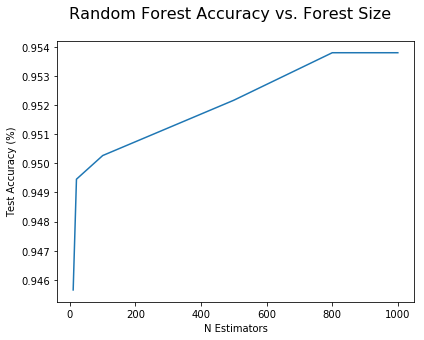

In [98]:
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
plt.plot(rf_accuracy["param_n_estimators"], rf_accuracy["mean_test_score"] )
plt.xlabel( 'N Estimators')
plt.ylabel('Test Accuracy (%)')
plt.suptitle('Random Forest Accuracy vs. Forest Size', fontsize = 16)

## Support Vector Machine

An SVM model identifies a hyperplane in an N-dimensional space that maximizes the distance between the distinct classes. For the SVM model, we will once again build a model using parameter tuning.   We now apply support vector machines with a radial basis function on the spam and ham dataset. 

Again, we use GridSearchCV to construct the models of parameter combinations.
The following parameters will be used:

- kernel: specifies kernel type to be used in algorithm, default=rbf

- C: Regularization parameter, the strength of the regularization is inversely proportional to C.

- gamma: kernel coefficient for rbf 

Note that we also assign a `random_state` to the SVC classifier to ensure results are reproducible.

In [99]:
# https://scikit-learn.org/stable/modules/grid_search.html
# kernel  has choices 'sigmoid', 'poly', 'linear', 
svm_param_grid = {'kernel': [ 'rbf'],
              'C': [1,  10,  50, 100] ,
               'gamma' : [ 0.001, 0.005, 0.01, 0.05, 0.5  ] }
base_estimator = SVC(random_state = 1923)

svm_gs = GridSearchCV(estimator=base_estimator, 
                            param_grid=svm_param_grid,
                            scoring='accuracy',
                            n_jobs=-1,
                            cv=6
                        )

svm_gs_model = svm_gs.fit(prepared_strainX, strainY )

In [100]:
# Parameter setting that gave the best results
svm_gs_model.best_params_

{'C': 50, 'gamma': 0.005, 'kernel': 'rbf'}

In [101]:
# mean cross-validated score of the best estimator
svm_gs_model.best_score_

0.9399448786959348

In [102]:
y_pred_svm = svm_gs_model.predict( prepared_stestX )

In [103]:
cm_svm = report_confusion_matrix( stestY, y_pred_svm , "Support Vector Machine") 

Data set:  Support Vector Machine
Accuracy (%) : 93.59
F1 Score (%) : 91.77
Precision (%): 92.94
Recall   (%) : 90.63
MCC (%)      : 86.55

 Confusion Matrix: 

   329    34
    25   533



The Support vector machine performance metrics show 

*   an accuracy of $\color{red}{\text{93.59%}}$ on the test dataset.

*   a precision of $\color{red}{\text{92.94%}}$ and recall of $\color{red}{\text{90.63%}}$.

*   the model performance is not as strong as the AdaBoost model.

In [104]:
#
# Plots the most importance features from a model that
# implements feature_importances_ method
# ----------------------------------------------------------------
def plot_spam_feature_importance_svm(svmModel, X_data, y_data, num_features=10 ):

    np.seterr(invalid='ignore')
    
    perm_importance = permutation_importance(svmModel, X_data, y_data)

    #sorted_idx = perm_importance.importances_mean.argsort()
    #plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
    #plt.xlabel("Permutation Importance")

    df_feature_importance = pd.DataFrame(
    {   
       'Feature': spam_columns[:57], 
       'Importance': perm_importance.importances_mean
    })
    df_plotted = df_feature_importance.sort_values('Importance', ascending=False)[:num_features]
    
    plt = sns.barplot(y='Feature', x = 'Importance', data = df_plotted)
    plt.set_title("Feature Importance Ranked\n{0}".format(svmModel.__class__.__name__ ), fontsize=20)




# Voting Classifier


Finally, we try the Voting classifier, another ensemble classifier, that combines the optimal models from the previous approaches. The `sckikit-learn` library Voting classifier combines several machine learning classifiers by using a majority vote to predict the classification label. 

For example, if we have $M$ binary classification models $f_1, f_2, \ldots f_{M}$ and an observation $X$, where each model $f_i$ assigns the value of either $f_i(X) = 1$ or $f_i(X) = -1$, then the voting classifier $VC(X)$ could be defined as:

$$VC(X) = \text{sgn}( \sum_{i=1}^{M} f_i(X) )$$


To avoid ties, it is important that the number $M$ of models be odd.

### Tuning

We have observed that weaker models can reduce the accuracy of the voting classifier, thus we will include an odd number of our best 3 models.

The predicted class in the Voting classifier is the mode selection from the individual classifiers.
We include the Random Forest, Adaboost and Support Vector Machine with radial basis models as constituent votes of the Voting classifier model.
We exclude the Stochastic Gradient Descent and KNN models as these demonstrated inferior performance.

In [105]:
clf_rf = rf_gs_model.best_estimator_
clf_svm = svm_gs_model.best_estimator_
clf_adaboost = adaboost_gs_model.best_estimator_

In [106]:
eclf = VotingClassifier(
    estimators=[('rf', clf_rf), ('ada', clf_adaboost) , ('svm', clf_svm)],
    voting='hard')

In [107]:
fit_eclf_model = eclf.fit( prepared_strainX, strainY )

In [108]:
y_pred_eclf = fit_eclf_model.predict( prepared_stestX )

### Results

The results below show that the accuracy of the voting classifier on the test data exceeds the accuracy of all its constituent voting models.
This is a remarkable demonstration that wisdom of the crowds appears to work.  In this case,  the weaknesses of the best model (the Adaboost)
are complemented by the predictions of Random Forest and Support Vector Machine.

In [109]:
cm_eclf = report_confusion_matrix( stestY, y_pred_eclf , "Ensemble") 

Data set:  Ensemble
Accuracy (%) : 95.77
F1 Score (%) : 94.56
Precision (%): 95.76
Recall   (%) : 93.39
MCC (%)      : 91.11

 Confusion Matrix: 

   339    24
    15   543



In [110]:
perf_ada = performance_statistics(cm_adaboost)
perf_rf  = performance_statistics(cm_rf2)
perf_svm = performance_statistics(cm_svm)
perf_eclf = performance_statistics(cm_eclf)
perf_knn = performance_statistics(cm_knn)
perf_sgd = performance_statistics(cm_sgd)

# $\color{blue}{\text{Model Evaluation and Selection}}$

Our comparison of all the models is shown in the table below.

We see that the best model is the $\color{blue}{\text{Voting classifier}}$ with $\color{red}{\text{95.8%}}$ accuracy on the test data.

It is followed by $\color{blue}{\text{AdaBoost}}$ model with $\color{red}{\text{95.7%}}$ accuracy.

We display the summary of the model performance in the table below.

*  The Voting classifier likewise beats all other models.  

*  The Adaboost, Random Forest models are very close in performance.

*  Support Vector Machine, Stochastic Gradient descent are close at a 3rd tier of performance.

*  KNN is the weakest model and significantly underperforms all others.

*  The ranking by accuracy is consistent with the ranking by MCC, the other useful key statistic.

Based on the performance statistics, we recommend that use of the Voting Classifier in email spam detection for this dataset.

In [111]:
model_comparison = pd.DataFrame( [perf_ada, perf_rf , perf_svm,perf_eclf , perf_knn, perf_sgd],
                                index = ['AdaBoost', 'RandForest', 'SuppVector', 'Voting' , 'KNN', 'StochGrad']  ,
                               columns = [ 'accuracy', 'precision', 'recall', 'F1', 'MCC', 'TP', 'FP', 'FN', 'TN' ]   ) 
                                                                                                         

In [112]:
import warnings
warnings.filterwarnings('ignore')
heading_properties = [('font-size', '18px')]

cell_properties = [('font-size', '16px')]

dfstyle = [dict(selector="th", props=heading_properties), dict(selector="td", props=cell_properties),
          dict(selector="caption", props=[("text-align", "center"), ("font-size", "18px"), ("color", 'blue') ] ) ]
          
model_comparison.sort_values('accuracy', ascending = False ).style.set_table_styles(dfstyle).set_precision(3).set_caption("Model Performance Ranked by Accuracy")

,accuracy,precision,recall,F1,MCC,TP,FP,FN,TN
Voting,0.958,0.958,0.934,0.946,0.911,339,15,24,543
AdaBoost,0.957,0.942,0.948,0.945,0.909,344,21,19,537
RandForest,0.953,0.955,0.926,0.940,0.902,336,16,27,542
SuppVector,0.936,0.929,0.906,0.918,0.865,329,25,34,533
StochGrad,0.923,0.915,0.887,0.901,0.838,322,30,41,528
KNN,0.911,0.912,0.857,0.884,0.813,311,30,52,528


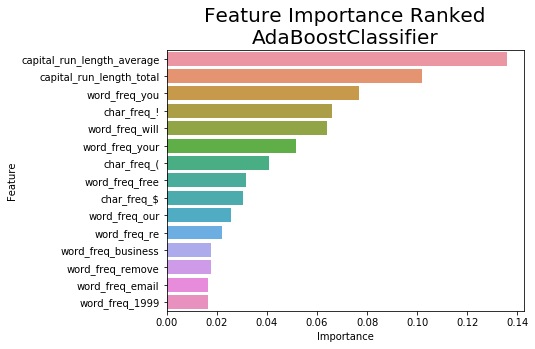

In [113]:
plot_spam_feature_importance(adaboost_gs_model.best_estimator_ , num_features = 15 )

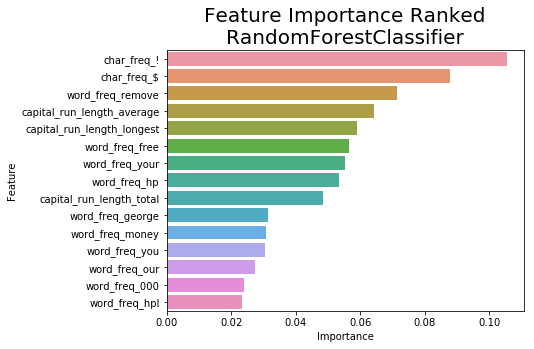

In [114]:
plot_spam_feature_importance(rf_gs_model.best_estimator_ , num_features = 15 )

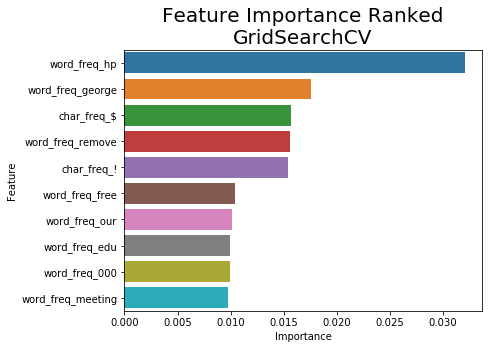

In [115]:
# This computation is very time consuming

plot_spam_feature_importance_svm( svm_gs_model, prepared_strainX, strainY )

It is worth understanding the features that drive each model.   The Random Forest, AdaBoost models allow us to compute feature importance.
The Support Vector Machine model allows us to compute permutation importance which is akin to feature importance but more computationally intensive.

We see that the top 15 features of Random Forest and AdaBoost are comparable.  They have many features in common.  We conclude that:

*   For example, `capital_run_length_average` is the top feature for AdaBoost and the 4th top feature of RandomForest.

*   The Support Vector Machine model does not include any of the capital run features among its top 10.  This suggests that SVM is not using those features efficiently in prediction.

# $\color{blue}{\text{Discussion}}$

We have determined that a Voting Classifier model can outperform its 3 constituent models by accuracy or Matthews correlation coefficient.
This voting classifier is demonstrated on a famous dataset the `spambase` dataset of emails.

There are some important caveats to generalizing our findings more broadly.

*   The `spambase` emails may not be representative of all email ham and spam.  
    +  The data shows a high propertion of the term `hpl` and `george`.  These are likely atypical words unless your name is `George` or your workplace is `HP`.
    +  The data is old.  Created in 1999, `spambase` predates social media and may reflect older word usage.


*   `spambase` does not provide direct access to the corpus of text.   
    +  Having the entire text message body for each email would allow more detailed feature extraction.
    +  Other datasets with text corpus have allowed spam detection rates over 98%.   Such a high accuracy rate is unattainable on the `spambase` dataset in our opinion.

# $\color{blue}{\text{Appendix}}$

We include some code used in testing our utility functions.

In [116]:
actual_y = [ False, False , True, True,  False , False, True , True , False, True]
pred_y   = [ True , False , True, False,False , True,  True,  True , True, True]

cm_test = confusion_matrix( actual_y, pred_y)

In [117]:
cm_test2 = report_confusion_matrix(actual_y, pred_y , "Test")

Data set:  Test
Accuracy (%) : 60.00
F1 Score (%) : 66.67
Precision (%): 57.14
Recall   (%) : 80.00
MCC (%)      : 21.82

 Confusion Matrix: 

     4     1
     3     2

